#

Download the dataset from kaggle

In [1]:
! kaggle datasets download -d aeryss/lte-dataset

Dataset URL: https://www.kaggle.com/datasets/aeryss/lte-dataset
License(s): CC-BY-SA-4.0
  0% 0.00/2.03M [00:00<?, ?B/s]
100% 2.03M/2.03M [00:00<00:00, 28.1MB/s]


In [2]:
! unzip lte-dataset.zip

Archive:  lte-dataset.zip
  inflating: Dataset/bus/A_2017.11.30_16.48.26.csv  
  inflating: Dataset/bus/A_2018.01.25_16.33.53.csv  
  inflating: Dataset/bus/A_2018.01.25_17.27.30.csv  
  inflating: Dataset/bus/A_2018.01.25_18.02.07.csv  
  inflating: Dataset/bus/A_2018.01.25_19.50.40.csv  
  inflating: Dataset/bus/A_2018.01.26_11.26.26.csv  
  inflating: Dataset/bus/A_2018.01.27_10.58.49.csv  
  inflating: Dataset/bus/A_2018.01.27_11.12.23.csv  
  inflating: Dataset/bus/A_2018.01.27_12.10.00.csv  
  inflating: Dataset/bus/B_2018.01.25_16.33.45.csv  
  inflating: Dataset/bus/B_2018.01.25_17.27.27.csv  
  inflating: Dataset/bus/B_2018.01.25_18.02.03.csv  
  inflating: Dataset/bus/B_2018.01.25_19.50.43.csv  
  inflating: Dataset/bus/B_2018.01.27_10.58.49.csv  
  inflating: Dataset/bus/B_2018.01.27_11.12.22.csv  
  inflating: Dataset/bus/B_2018.01.27_12.09.59.csv  
  inflating: Dataset/car/A_2017.12.04_15.24.12.csv  
  inflating: Dataset/car/A_2017.12.05_07.24.29.csv  
  inflating: Dataset

In [4]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 29.9 MB/s eta 0:00:00


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Loading the dataset and handle non-numeric values

In [28]:

file_path = 'combined_LTE_data.csv'
lte_data = pd.read_csv(file_path, low_memory=False)

# Replace non-numeric values ('-') in 'RSRP', 'RSRQ', 'SNR' with NaN and convert to numeric
lte_data['RSRP'] = pd.to_numeric(lte_data['RSRP'], errors='coerce')
lte_data['RSRQ'] = pd.to_numeric(lte_data['RSRQ'], errors='coerce')
lte_data['SNR'] = pd.to_numeric(lte_data['SNR'], errors='coerce')

# Sample a subset of the data for testing
lte_data = lte_data.sample(frac=0.1, random_state=42)

# Data Cleaning and Preprocessing
lte_data['Timestamp'] = pd.to_datetime(lte_data['Timestamp'], format='%Y.%m.%d_%H.%M.%S', errors='coerce')
lte_data = lte_data.sort_values(by='Timestamp')

# Replace non-numeric entries in relevant columns with NaN and interpolate missing values
features_to_scale = ['Longitude', 'Latitude', 'Speed', 'RSRP', 'RSRQ', 'SNR', 'ServingCell_Distance']
lte_data[features_to_scale] = lte_data[features_to_scale].apply(pd.to_numeric, errors='coerce')
lte_data[features_to_scale] = lte_data[features_to_scale].interpolate(method='linear')

# Normalize the relevant features
scaler = MinMaxScaler()
lte_data[features_to_scale] = scaler.fit_transform(lte_data[features_to_scale])

# Feature Engineering
lte_data['Hour'] = lte_data['Timestamp'].dt.hour
lte_data['DayOfWeek'] = lte_data['Timestamp'].dt.dayofweek
features = ['Longitude', 'Latitude', 'Speed', 'RSRP', 'RSRQ', 'SNR', 'ServingCell_Distance', 'Hour', 'DayOfWeek']
target = 'RSRP'

# Sequence Creation

In [29]:


sequence_length = 10
def create_sequences(data, features, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:i + sequence_length].values)
        y.append(data[target].iloc[i + sequence_length])
    return np.array(X), np.array(y)

X, y = create_sequences(lte_data, features, target, sequence_length)

# Printing the shape of the dataset
print(f"Number of sequences created: {len(X)}")
print(f"Training data shape: {X.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model Building: Smaller LSTM Model
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(sequence_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model with Verbose Output
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Number of sequences created: 17442
Training data shape: (17442, 10, 9)
Epoch 1/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0282 - val_loss: 0.0088
Epoch 2/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0113 - val_loss: 0.0066
Epoch 3/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 4/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0054 - val_loss: 0.0061
Epoch 5/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0046 - val_loss: 0.0061


# Creating separate scalers for the features and the target

In [31]:

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Normalize the features
lte_data[features_to_scale] = feature_scaler.fit_transform(lte_data[features_to_scale])

# Normalize the target ('RSRP')
lte_data[['RSRP']] = target_scaler.fit_transform(lte_data[['RSRP']])

# Feature Engineering
lte_data['Hour'] = lte_data['Timestamp'].dt.hour
lte_data['DayOfWeek'] = lte_data['Timestamp'].dt.dayofweek
features = ['Longitude', 'Latitude', 'Speed', 'RSRP', 'RSRQ', 'SNR', 'ServingCell_Distance', 'Hour', 'DayOfWeek']
target = 'RSRP'

# Sequence Creation
sequence_length = 10
def create_sequences(data, features, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:i + sequence_length].values)
        y.append(data[target].iloc[i + sequence_length])
    return np.array(X), np.array(y)

X, y = create_sequences(lte_data, features, target, sequence_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model Building
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(sequence_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Evaluation
y_pred = model.predict(X_test)

# Reverse the normalization for the target only
y_test_rescaled = target_scaler.inverse_transform(np.expand_dims(y_test, axis=1))
y_pred_rescaled = target_scaler.inverse_transform(y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((y_test_rescaled - y_pred_rescaled) ** 2))
print(f"Root Mean Squared Error: {rmse}")

Epoch 1/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0461 - val_loss: 0.0098
Epoch 2/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0131 - val_loss: 0.0104
Epoch 3/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0082 - val_loss: 0.0073
Epoch 4/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 5/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0049 - val_loss: 0.0065
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Root Mean Squared Error: 0.08055183371436395


#Evaluation and visualizing

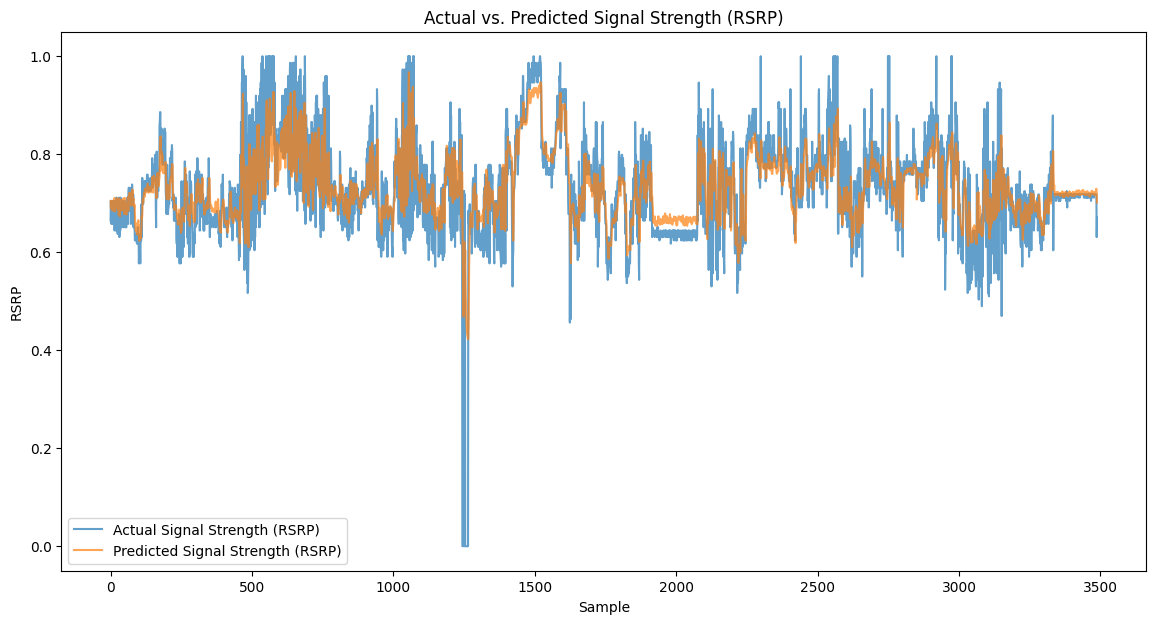

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'target_scaler' was already defined and used for scaling 'RSRP' in the previous steps
# Recompute the rescaled values for visualization
y_test_rescaled = target_scaler.inverse_transform(np.expand_dims(y_test, axis=1))
y_pred_rescaled = target_scaler.inverse_transform(y_pred)

# Visualize the actual vs. predicted signal strength
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual Signal Strength (RSRP)', alpha=0.7)
plt.plot(y_pred_rescaled, label='Predicted Signal Strength (RSRP)', alpha=0.7)
plt.title('Actual vs. Predicted Signal Strength (RSRP)')
plt.xlabel('Sample')
plt.ylabel('RSRP')
plt.legend()
plt.show()


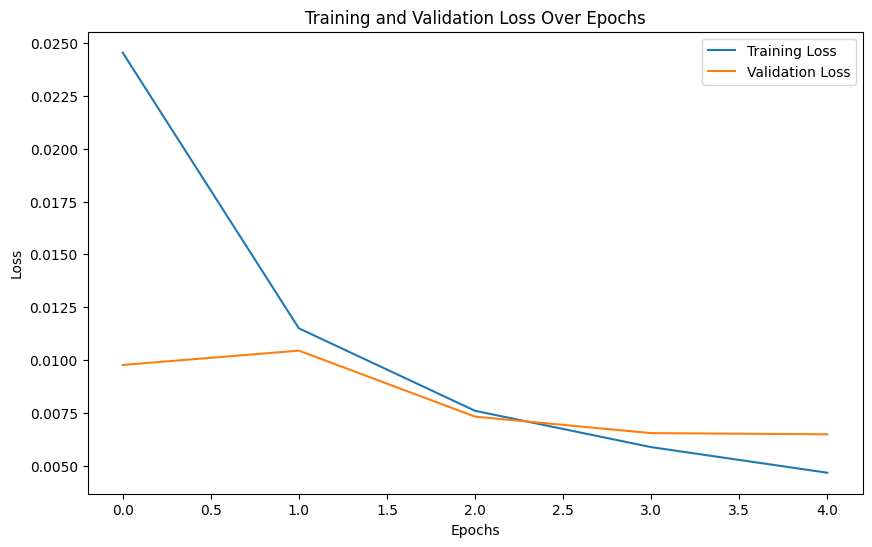

In [33]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


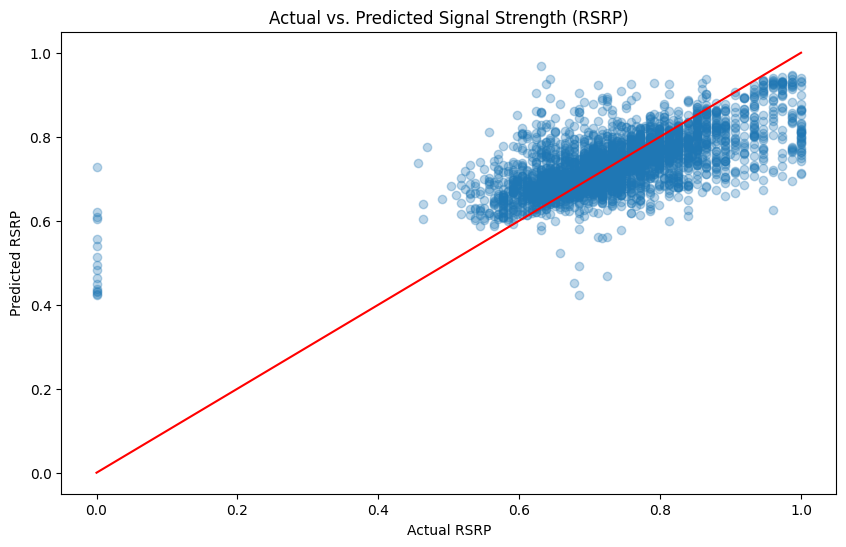

In [34]:
# Scatter plot of actual vs predicted RSRP
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.3)
plt.title('Actual vs. Predicted Signal Strength (RSRP)')
plt.xlabel('Actual RSRP')
plt.ylabel('Predicted RSRP')
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red')
plt.show()


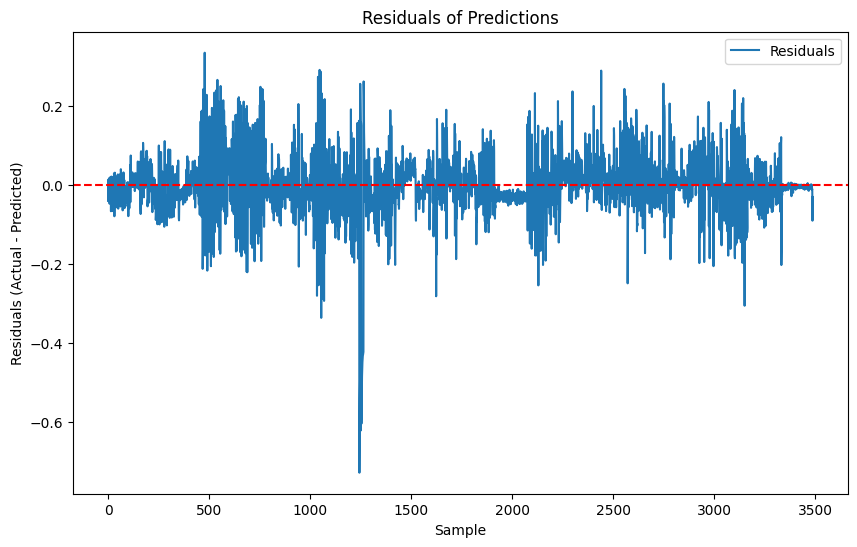

In [35]:
# Residuals plot
residuals = y_test_rescaled - y_pred_rescaled
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals of Predictions')
plt.xlabel('Sample')
plt.ylabel('Residuals (Actual - Predicted)')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()


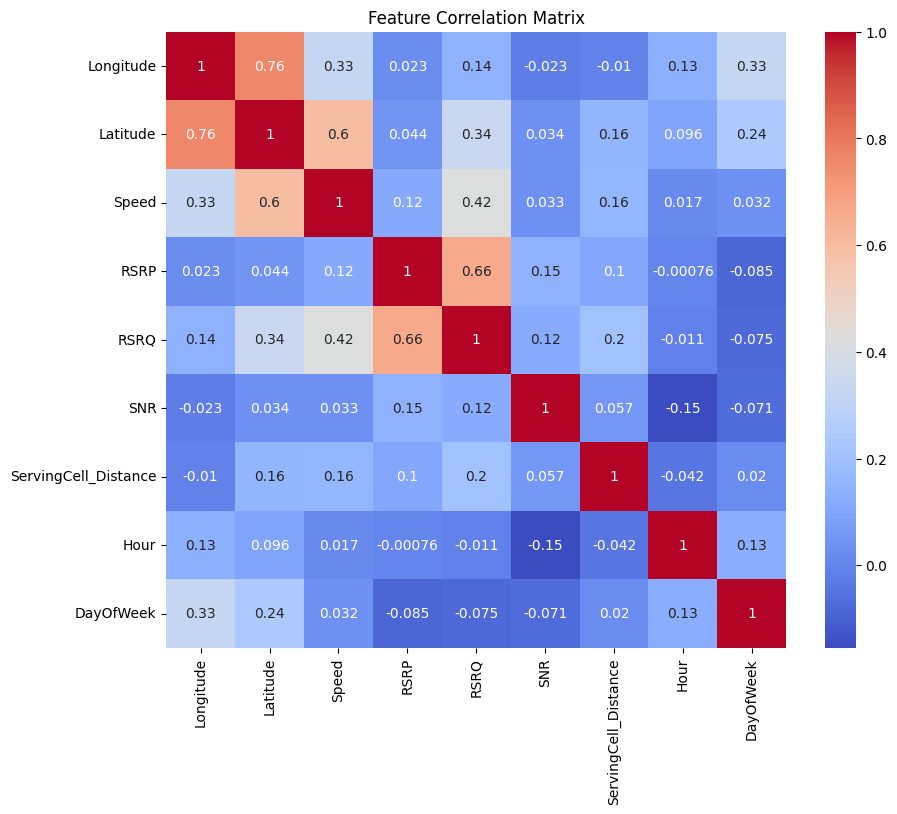

In [38]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = pd.DataFrame(X.reshape(-1, len(features)), columns=features).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()
